## Gaussian Copula Resmapling

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import projplot.proj_plot as pjp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import particle_resamplers as resampler
from pfjax.models import BMModel
from pfjax.experimental.models import LotVolModelLog
import optax
from jax import lax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
from pfjax.utils import lwgt_to_prob, continuous_cdf, interpolate_weights, argsort_marginal

# Brownian Motion Model

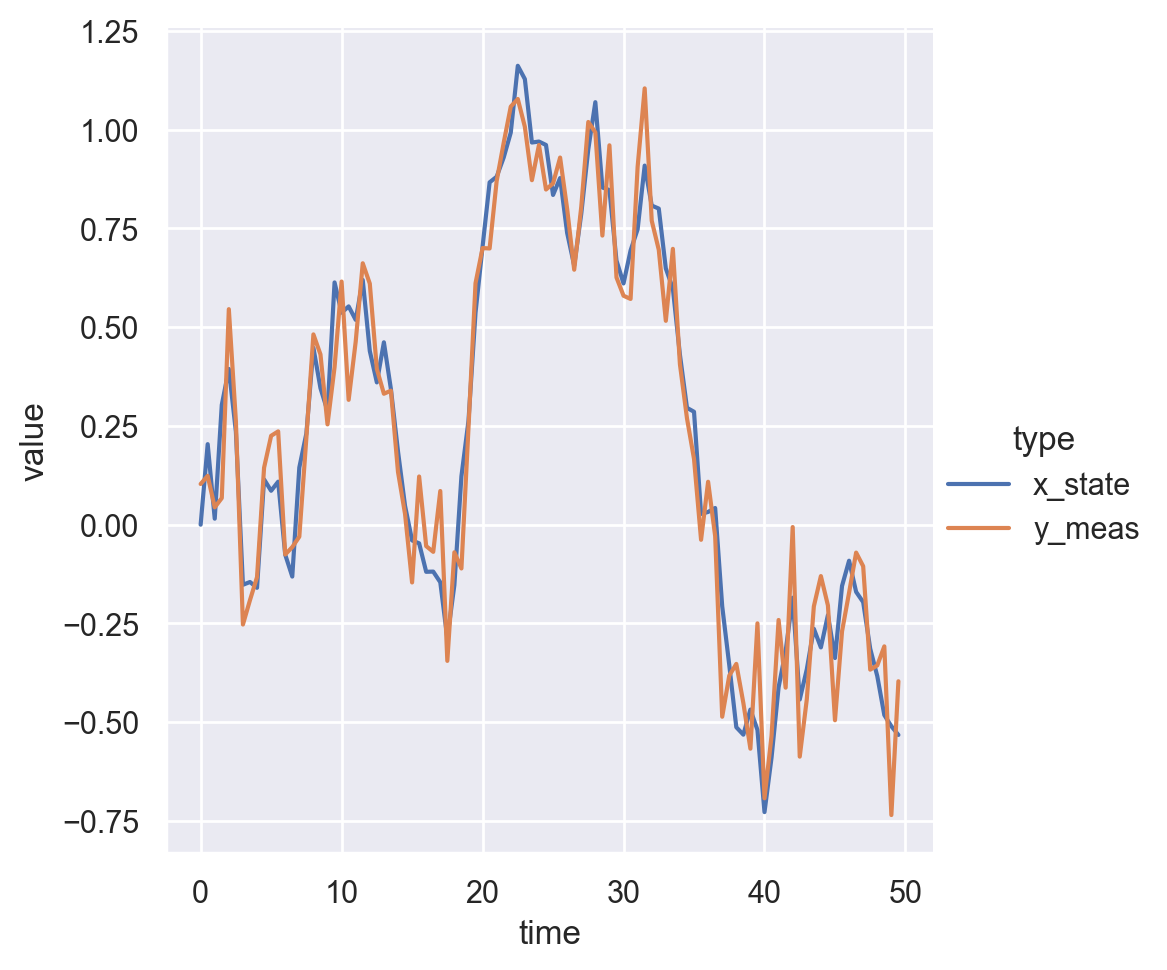

In [3]:
# parameter values
mu = 0.
sigma = .2
tau = .1
theta_true = jnp.array([mu, sigma, tau])

# data specification
dt = .5
n_obs = 100
x_init = jnp.array(0.)

# initial key for random numbers
key = jax.random.PRNGKey(0)

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = jax.random.split(key)
y_meas, x_state = pf.simulate(
    model=bm_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true
)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
);

## Loglikelihood Comparisons

In [4]:
def resample_continuous_bm (key, x_particles_prev, logw):
    """
    Continuous CDF resampler for the Brownian motion model with drift
    """
    p_shape = x_particles_prev.shape
    n_particles = p_shape[0]
    prob = lwgt_to_prob(logw)

    sorted_marginals = argsort_marginal(x_particles_prev, prob)

    U = random.uniform(key, shape=(n_particles,))
    x_particles = jax.vmap(
        lambda u: continuous_cdf(sorted_marginals["x"], sorted_marginals["w"], u), in_axes = (0))(U)
    return {
        "x_particles": x_particles,
    }

def bm_loglik_exact(theta, y_meas):
    """
    Exact loglikelihood of the BM model.
    """
    theta = jnp.atleast_2d(theta)
    return jax.vmap(lambda _theta: bm_model.loglik_exact(
        y_meas=y_meas, 
        theta=_theta
    ))(theta)

def bm_loglik_basic(theta, y_meas, key, n_particles):
    """
    Basic particle filter approximation of the loglikelihood.
    """
    theta = jnp.atleast_2d(theta)
    subkeys = jax.random.split(key, num=theta.shape[0])
    return jax.vmap(lambda _theta, _key: pf.particle_filter(
        model=bm_model,
        key=_key,
        y_meas=y_meas,
        n_particles=n_particles,
        theta=_theta,
        history=False,
        score=False,
        fisher=False
    )["loglik"])(theta, subkeys)

def bm_loglik_cont_approx(theta, y_meas, key, n_particles):
    """
    particle filter approximation of the loglikelihood using continuous CDF approximation 
    """
    theta = jnp.atleast_2d(theta)
    subkeys = jax.random.split(key, num=theta.shape[0])
    return jax.vmap(lambda _theta, _key: pf.particle_filter(
        model=bm_model,
        key=_key,
        y_meas=y_meas,
        n_particles=n_particles,
        resampler=resample_continuous_bm,
        theta=_theta,
        history=False,
        score=False,
        fisher=False
    )["loglik"])(theta, subkeys)

def bm_loglik_rb(theta, y_meas, key, n_particles):
    """
    Rao-Blackwellized particle filter approximation of the loglikelihood.
    """
    theta = jnp.atleast_2d(theta)
    subkeys = jax.random.split(key, num=theta.shape[0])
    return jax.vmap(lambda _theta, _key: pf.particle_filter_rb(
        model=bm_model,
        key=_key,
        y_meas=y_meas,
        n_particles=n_particles,
        theta=_theta,
        history=False,
        score=False,
        fisher=False
    )["loglik"])(theta, subkeys)

In [5]:
# projection plot specification
n_pts = 100 # number of evaluation points per plot
theta_lims = jnp.array([[-.5, .5], [.1, .4], [.05, .2]])  # plot limits for each parameter
theta_names = ["mu", "sigma", "tau"] # parameter names

In [6]:
# projection plots for exact loglikelihood
df_exact = pjp.proj_plot(
    fun=jax.jit(partial(bm_loglik_exact, y_meas=y_meas)),
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

In [7]:
# projection plots for basic particle filter
n_particles_basic = 2500
key, subkey = jax.random.split(key)
bm_ll_basic = jax.jit(partial(bm_loglik_basic, y_meas=y_meas,
                             n_particles=n_particles_basic, key=subkey))

%timeit bm_ll_basic(theta_true)

df_basic = pjp.proj_plot(
    fun=bm_ll_basic,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

42.4 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# projection plots for rao-blackwellized particle filter
n_particles_rb = 400
key, subkey = jax.random.split(key)
bm_ll_rb = jax.jit(partial(bm_loglik_rb, y_meas=y_meas,
                             n_particles=n_particles_rb, key=subkey))

%timeit bm_ll_rb(theta_true)

df_rb = pjp.proj_plot(
    fun=bm_ll_rb,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

191 ms ± 923 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# projection plots for continuous resampling particle filter
n_particles_cont = 2500
key, subkey = jax.random.split(key)
bm_ll_cont = jax.jit(partial(bm_loglik_cont_approx, y_meas=y_meas,
                             n_particles=n_particles_cont, key=subkey))

%timeit bm_ll_cont(theta_true)

df_cont = pjp.proj_plot(
    fun=bm_ll_cont,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

1.11 s ± 7.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


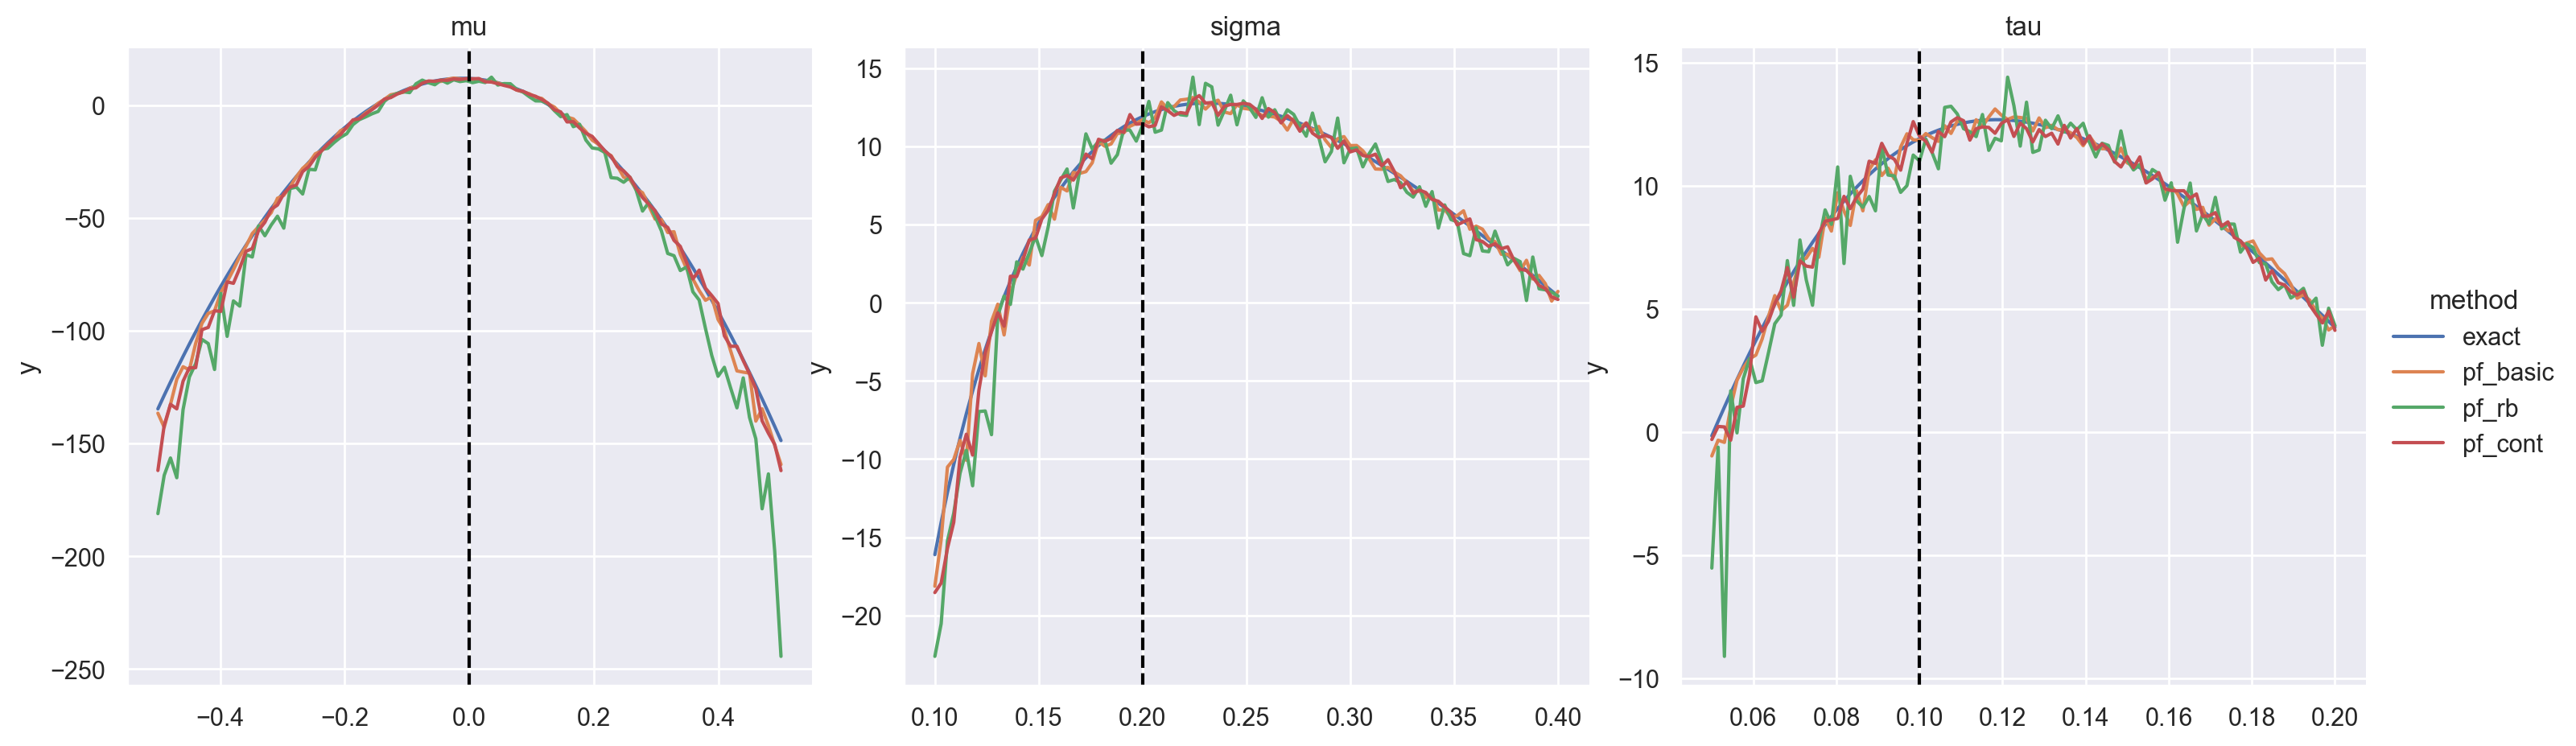

In [10]:
#merge data frames and plot them
plot_df = pd.concat([df_exact, df_basic, df_rb, df_cont], ignore_index=True)
plot_df["method"] = np.repeat(["exact", "pf_basic", "pf_rb", "pf_cont"], len(df_exact["x_opt"]))
rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", 
    hue="method",
    col="x_opt",
    col_wrap = 3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.set_titles(col_template="{col_name}")
rp.set(xlabel=None)
# add true parameter values
for ax, theta in zip(rp.axes.flat, theta_true):
    ax.axvline(theta, linestyle="--", color="black")

### Check Particle Filter Approximations

In [11]:
import pfjax.experimental as pfex

def to_phi(theta):
    """
    Helper function to convert theta to phi.
    """
    return jnp.array([theta[0], jnp.log(theta[1]), jnp.log(theta[2])])

def to_theta(phi):
    """
    Helper function to convert phi to theta.
    """
    return jnp.array([phi[0], jnp.exp(phi[1]), jnp.exp(phi[2])])

def prop_lpdf(self, x_curr, x_prev, y_curr, theta):
    """
    Add proposal log-pdf to bm_model.
    """
    return self.state_lpdf(x_curr=x_curr, x_prev=x_prev, theta=theta)

def bm_loglik_exact(theta, y_meas):
    """
    Exact loglikelihood of the BM model.
    """
    return bm_model.loglik_exact(y_meas=y_meas, theta=theta)

def bm_loglik_stan(theta, y_meas, key, n_particles, resampler = pf.particle_resamplers.resample_multinomial):
    """
    Standard particle filter approximation of the loglikelihood.
    """
    pf_out = pfex.particle_filter(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        resampler = resampler,
        n_particles=n_particles,
        history=False
    )
    return pf_out["loglik"]

def bm_loglik_rb(theta, y_meas, key, n_particles):
    """
    Rao-Blackwellized particle filter approximation of the negative loglikelihood.
    """
    pf_out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        history=False
    )
    return pf_out["loglik"]

def bm_loglik_cont(theta, y_meas, key, n_particles):
    """
    Rao-Blackwellized particle filter approximation of the negative loglikelihood.
    """
    pf_out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        resampler=resample_continuous_bm,
        n_particles=n_particles,
        history=False
    )
    return pf_out["loglik"]

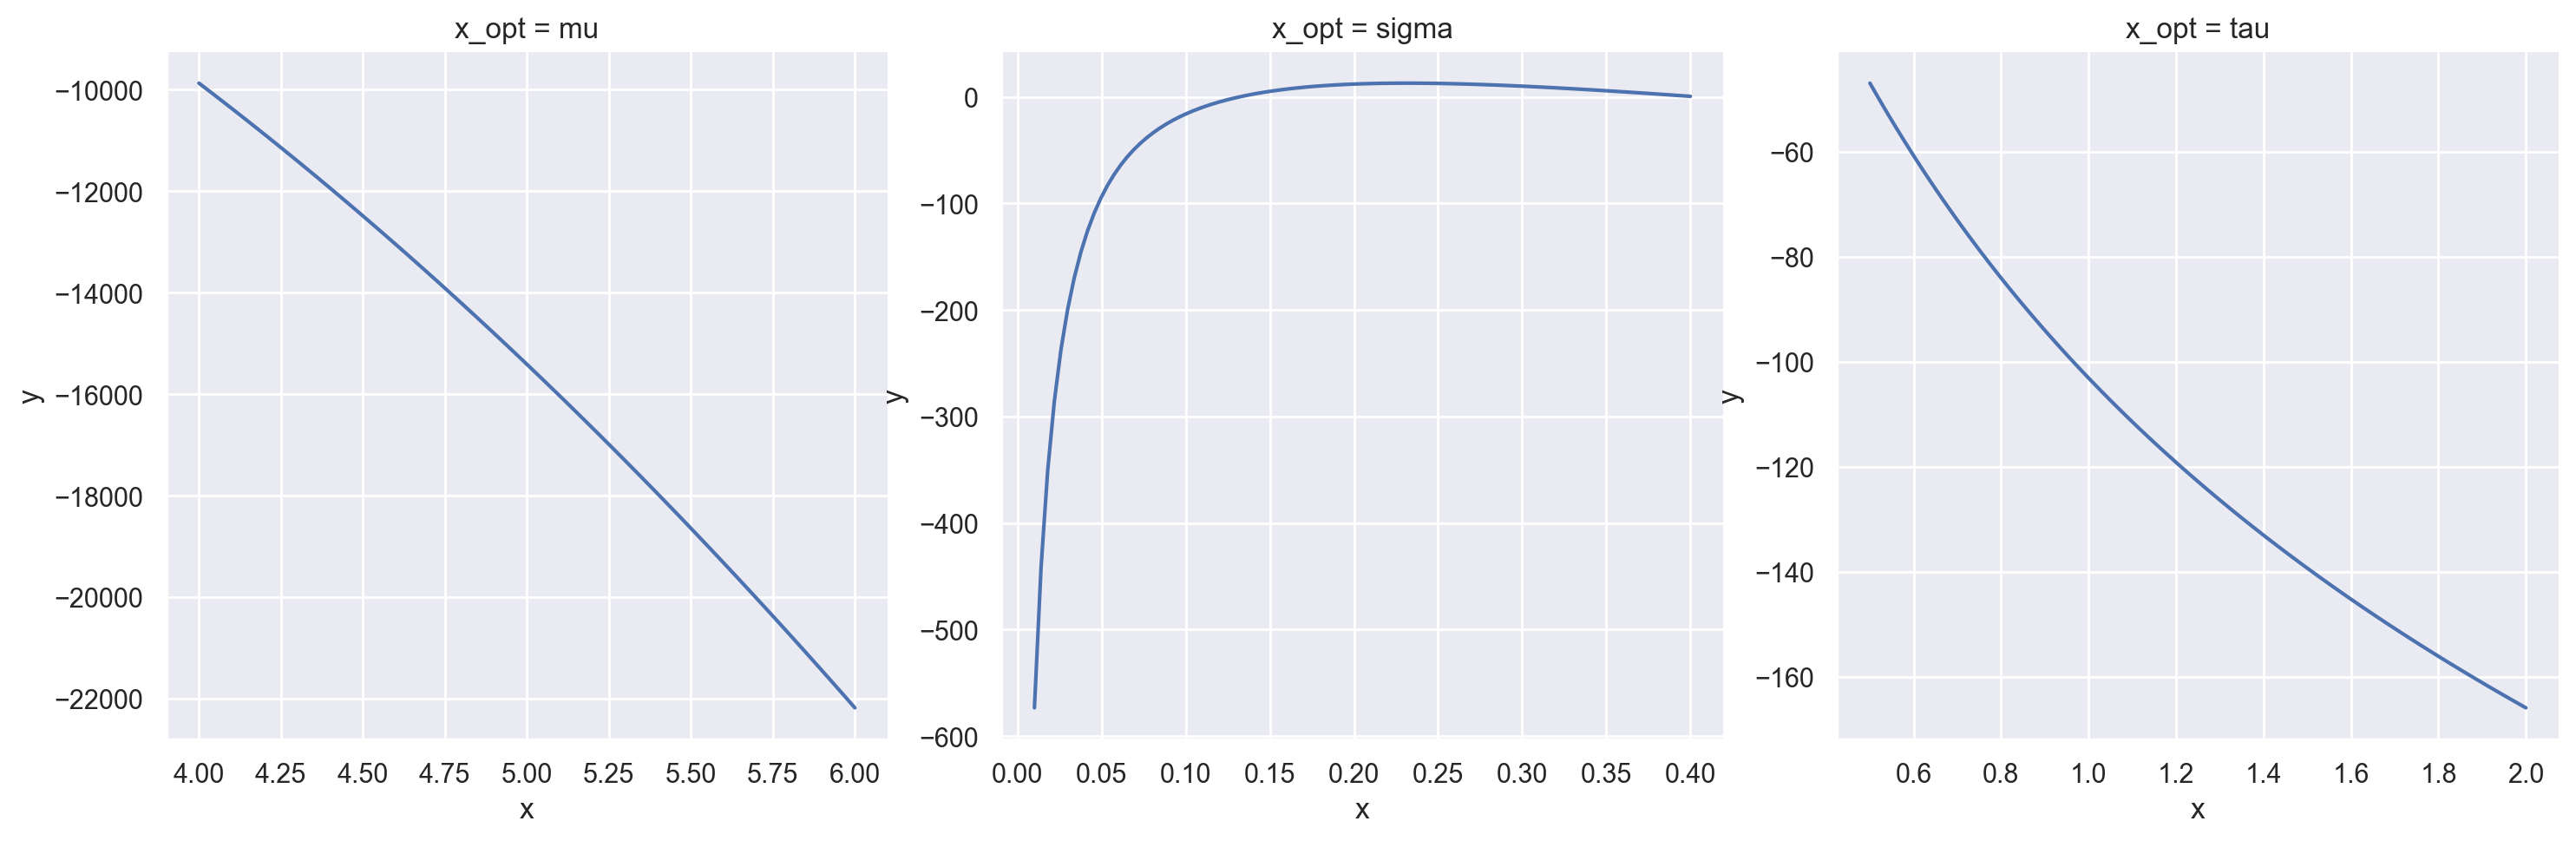

In [12]:
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for `projplot.projxvals()` and `projplot.projdata()`.

    Won't need this for upcoming interface of projplot.
    """
    xvals = pjp.proj_xvals(x, x_lims, n_pts)
    return pjp.proj_data(fun, xvals, x_names) #, is_vectorized=False)


# plot exact likelihood
theta_lims = jnp.array([[4., 6.], [.01, .4], [.5, 2]])  # for n_obs = 100
# theta_lims = jnp.array([[4., 5.5], [.01, .4], [.8, 1.4]]) # for n_obs = 10
# phi_true = to_phi(theta_true)
# phi_lims = to_phi(theta_lims)

theta_names = ["mu", "sigma", "tau"]
n_pts = 100

# calculate projection plot
df_exact = pjp.proj_plot(
    fun=jax.jit(partial(bm_loglik_exact, y_meas=y_meas)),
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    plot = True
)

43.1 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


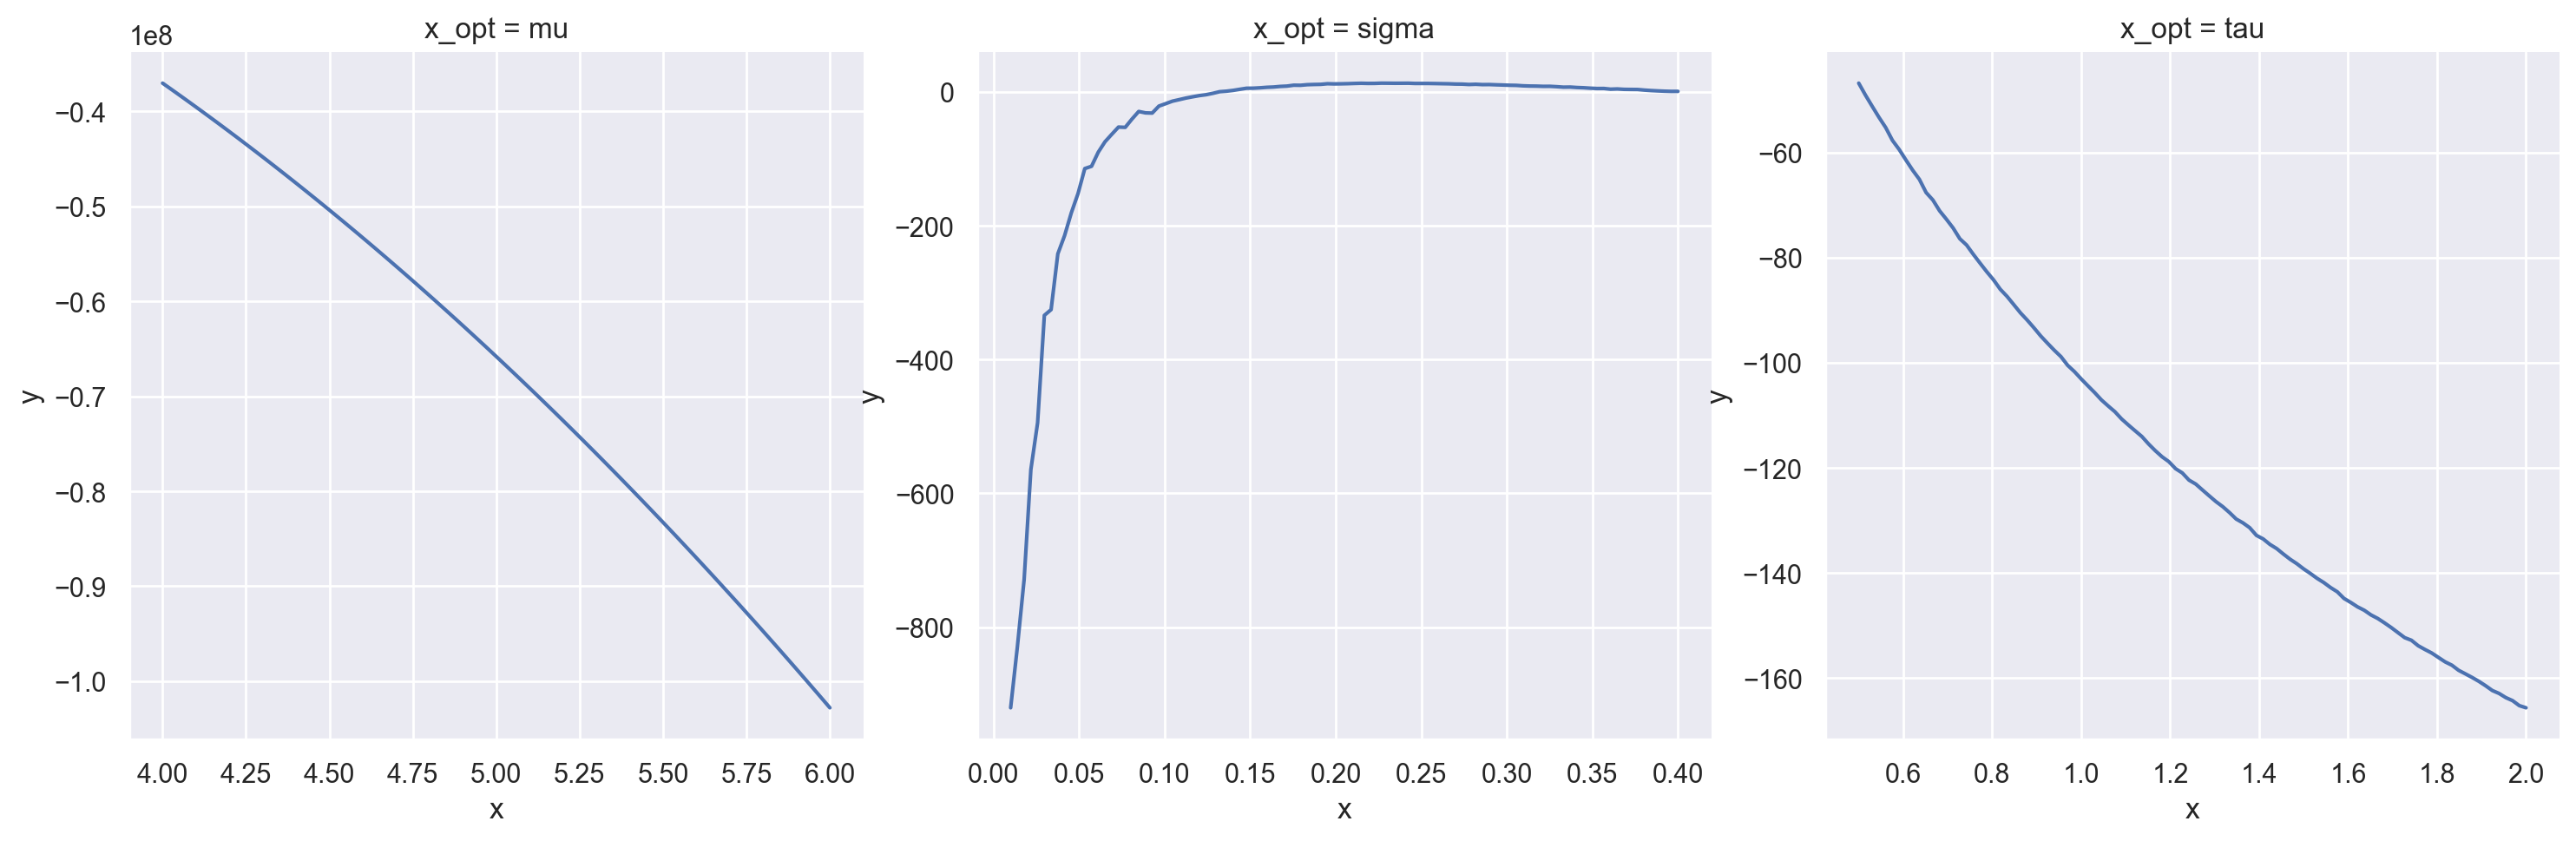

In [13]:
# standard particle filter (multinomial resampling)

n_particles_stan = 2500

key, subkey = random.split(key)
bm_ll_stan = jax.jit(partial(bm_loglik_stan, y_meas=y_meas,
                             n_particles=n_particles_stan, key=subkey))

%timeit bm_ll_stan(theta_true)

# df_stan = proj_data(bm_ll_stan,
#                     theta_true, theta_lims, theta_names)

# calculate projection plot
df_stan = pjp.proj_plot(
    fun=bm_ll_stan,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    plot = True
)

18.9 ms ± 976 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


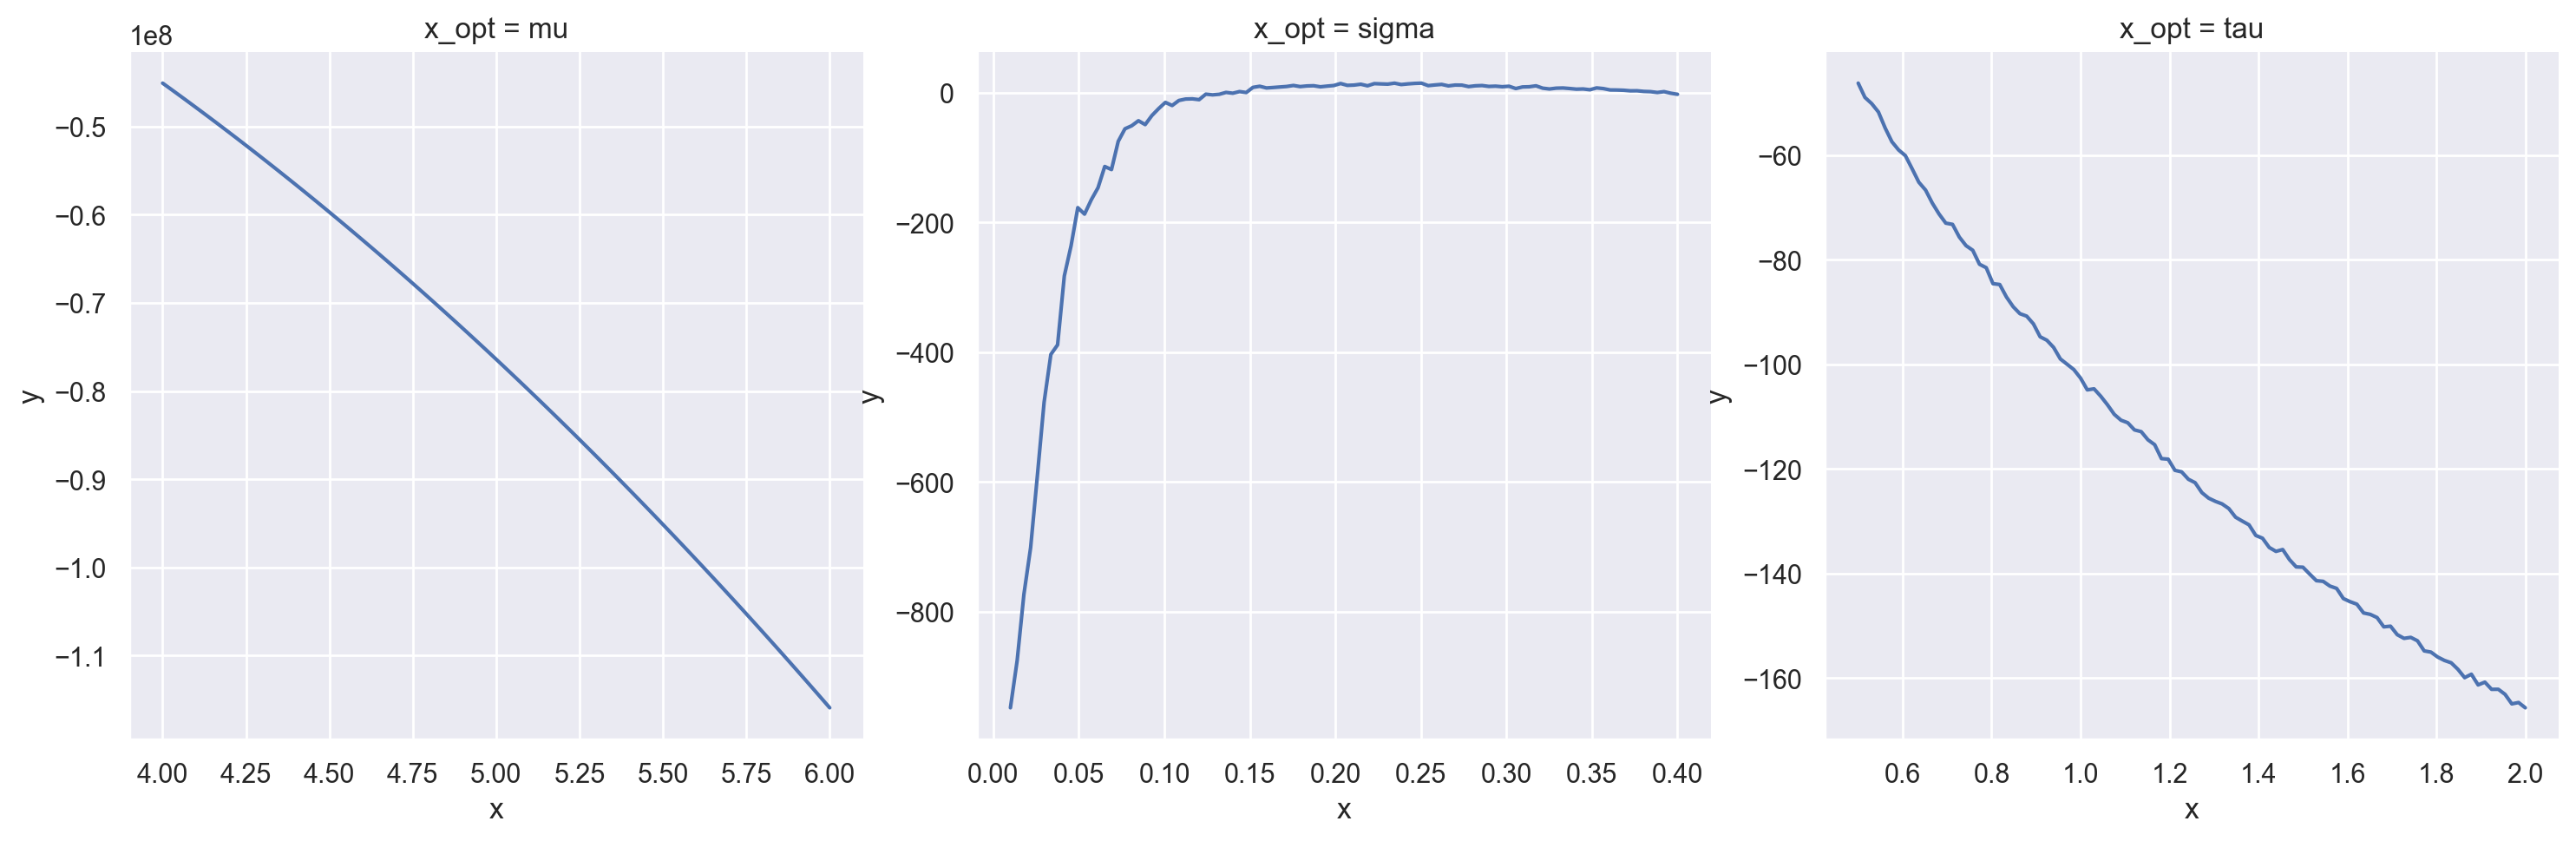

In [14]:
# rao-blackwellized particle filter

n_particles_rb = 100

key, subkey = random.split(key)
bm_ll_rb = jax.jit(partial(bm_loglik_rb, y_meas=y_meas,
                             n_particles=n_particles_rb, key=subkey))

%timeit bm_ll_rb(theta_true)

# df_rb = proj_data(bm_ll_rb,
#                     theta_true, theta_lims, theta_names)

# calculate projection plot
df_rb = pjp.proj_plot(
    fun=bm_ll_rb,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    plot = True
)

206 ms ± 4.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


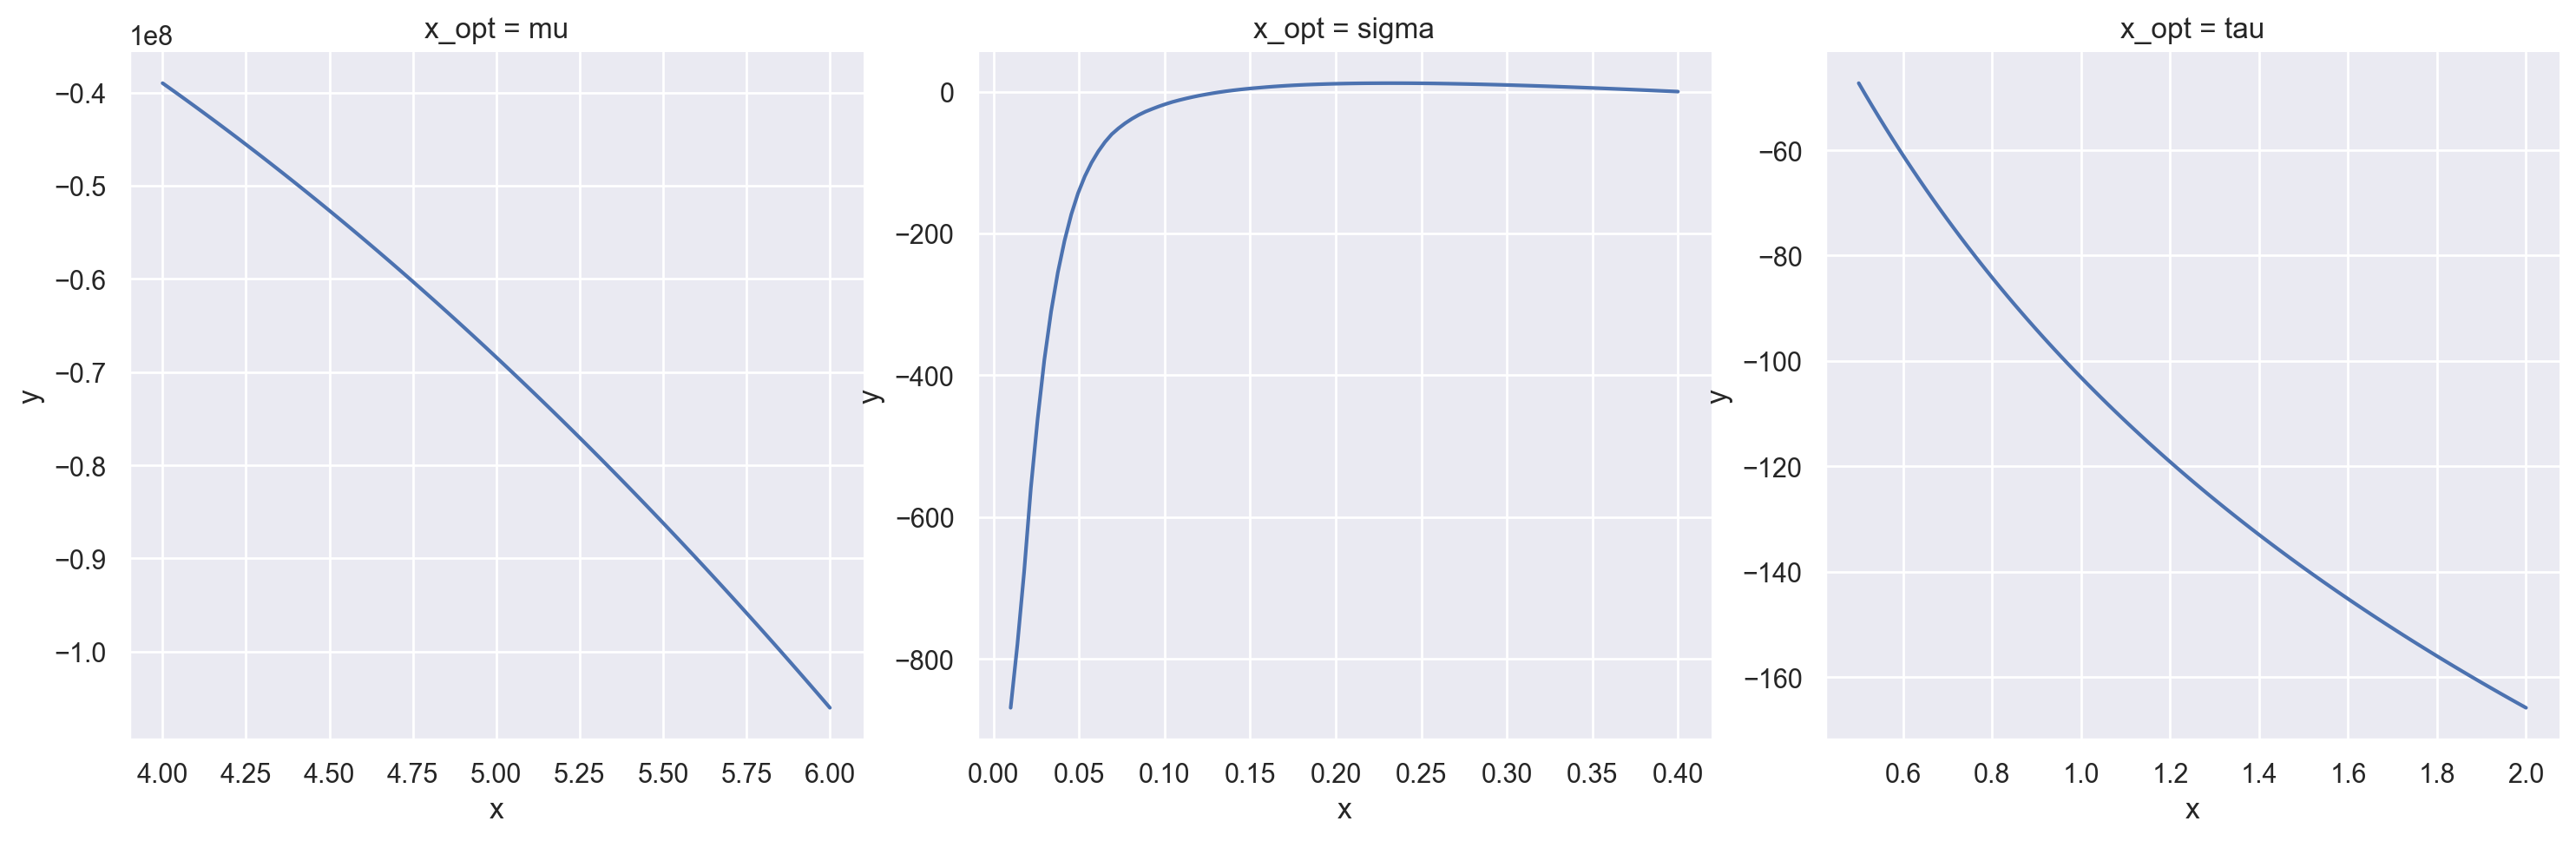

In [15]:
# continuous-cdf particle filter
# resample_continuous_bm

n_particles_cont = 1000

# key, subkey = random.split(key)
# bm_ll_cont = jax.jit(partial(bm_loglik_cont, y_meas=y_meas,
#                              n_particles=n_particles_cont, key=subkey))

# %timeit bm_ll_cont(theta_true)

# df_cont = proj_data(bm_ll_cont,
#                   theta_true, theta_lims, theta_names)


# standard particle filter (multinomial resampling)

key, subkey = random.split(key)
bm_ll_cont = jax.jit(partial(bm_loglik_stan, y_meas=y_meas, resampler=resample_continuous_bm,
                             n_particles=n_particles_cont, key=subkey))

%timeit bm_ll_cont(theta_true)

# df_cont = proj_data(bm_ll_cont,
#                     theta_true, theta_lims, theta_names)

# calculate projection plot
df_cont = pjp.proj_plot(
    fun=bm_ll_cont,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    plot = True
)

## Check Score Function

Here we'll compare three different approximations:

1.  Automatic differentiation through the standard particle filter.  This is know to produce biased results (\cite{corenflos_etal21}).

2.  A modification of the standard particle filter developed by \cite{cappe_moulines05} of which the bi-product is the score.  This algorithm is unbiased and scales as $\bO(NT)$, but we have $\var(\widehat{\nabla \ell}_N(\tth)) = \bO{T^2/N}$ (\cite{poyiadjis_etal11}).

3.  A bi-product of the Rao-Blackwellized particle filter developped by \cite{poyiadjis_etal11}.

For simplicity we'll just check the various approximations at the true value of $\tth$.

In [18]:
# various score functions
bm_score_exact = jax.jit(jax.grad(partial(bm_loglik_exact, y_meas=y_meas)))

@partial(jax.jit, static_argnums=(2,))
def bm_score_auto(theta, key, n_particles):
    return jax.grad(bm_loglik_stan)(theta, y_meas, key, n_particles)


@partial(jax.jit, static_argnums=(2,))
def bm_score_acc(theta, key, n_particles):
    out = pfex.particle_filter(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=False,
        history=False
    )
    return out["score"]


@partial(jax.jit, static_argnums=(2,))
def bm_score_rb(theta, key, n_particles): 
    out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=False,
        history=False
    )
    return out["score"]


@partial(jax.jit, static_argnums=(2,))
def bm_score_cont(theta, key, n_particles): 
    out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        resampler = resample_continuous_bm,
        n_particles=n_particles,
        score=True,
        fisher=False,
        history=False
    )
    return out["score"]

In [57]:
key = random.PRNGKey(0)
n_particles_stan = 2500
n_particles_rb = 100
n_sim = 100
n_particles_cont = 500
key, *subkeys = random.split(key, n_sim+1)

# check timings
%timeit bm_score_auto(theta_true, key, n_particles_stan)
%timeit bm_score_acc(theta_true, key, n_particles_stan)
%timeit bm_score_rb(theta_true, key, n_particles_rb)
%timeit bm_score_cont(theta_true, key, n_particles_cont)

55.3 ms ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
52.7 ms ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
40 ms ± 4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
919 ms ± 270 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
# repeat calculation nsim times
score_exact = bm_score_exact(theta_true)
score_auto = []
score_acc = []
score_rb = []
score_cont = []

for i in range(n_sim):
    score_auto += [bm_score_auto(theta_true, subkeys[i], n_particles_stan)]
    score_acc += [bm_score_acc(theta_true, subkeys[i], n_particles_stan)]
    score_rb += [bm_score_rb(theta_true, subkeys[i], n_particles_rb)]
    score_cont += [bm_score_cont(theta_true, subkeys[i], n_particles_cont)]

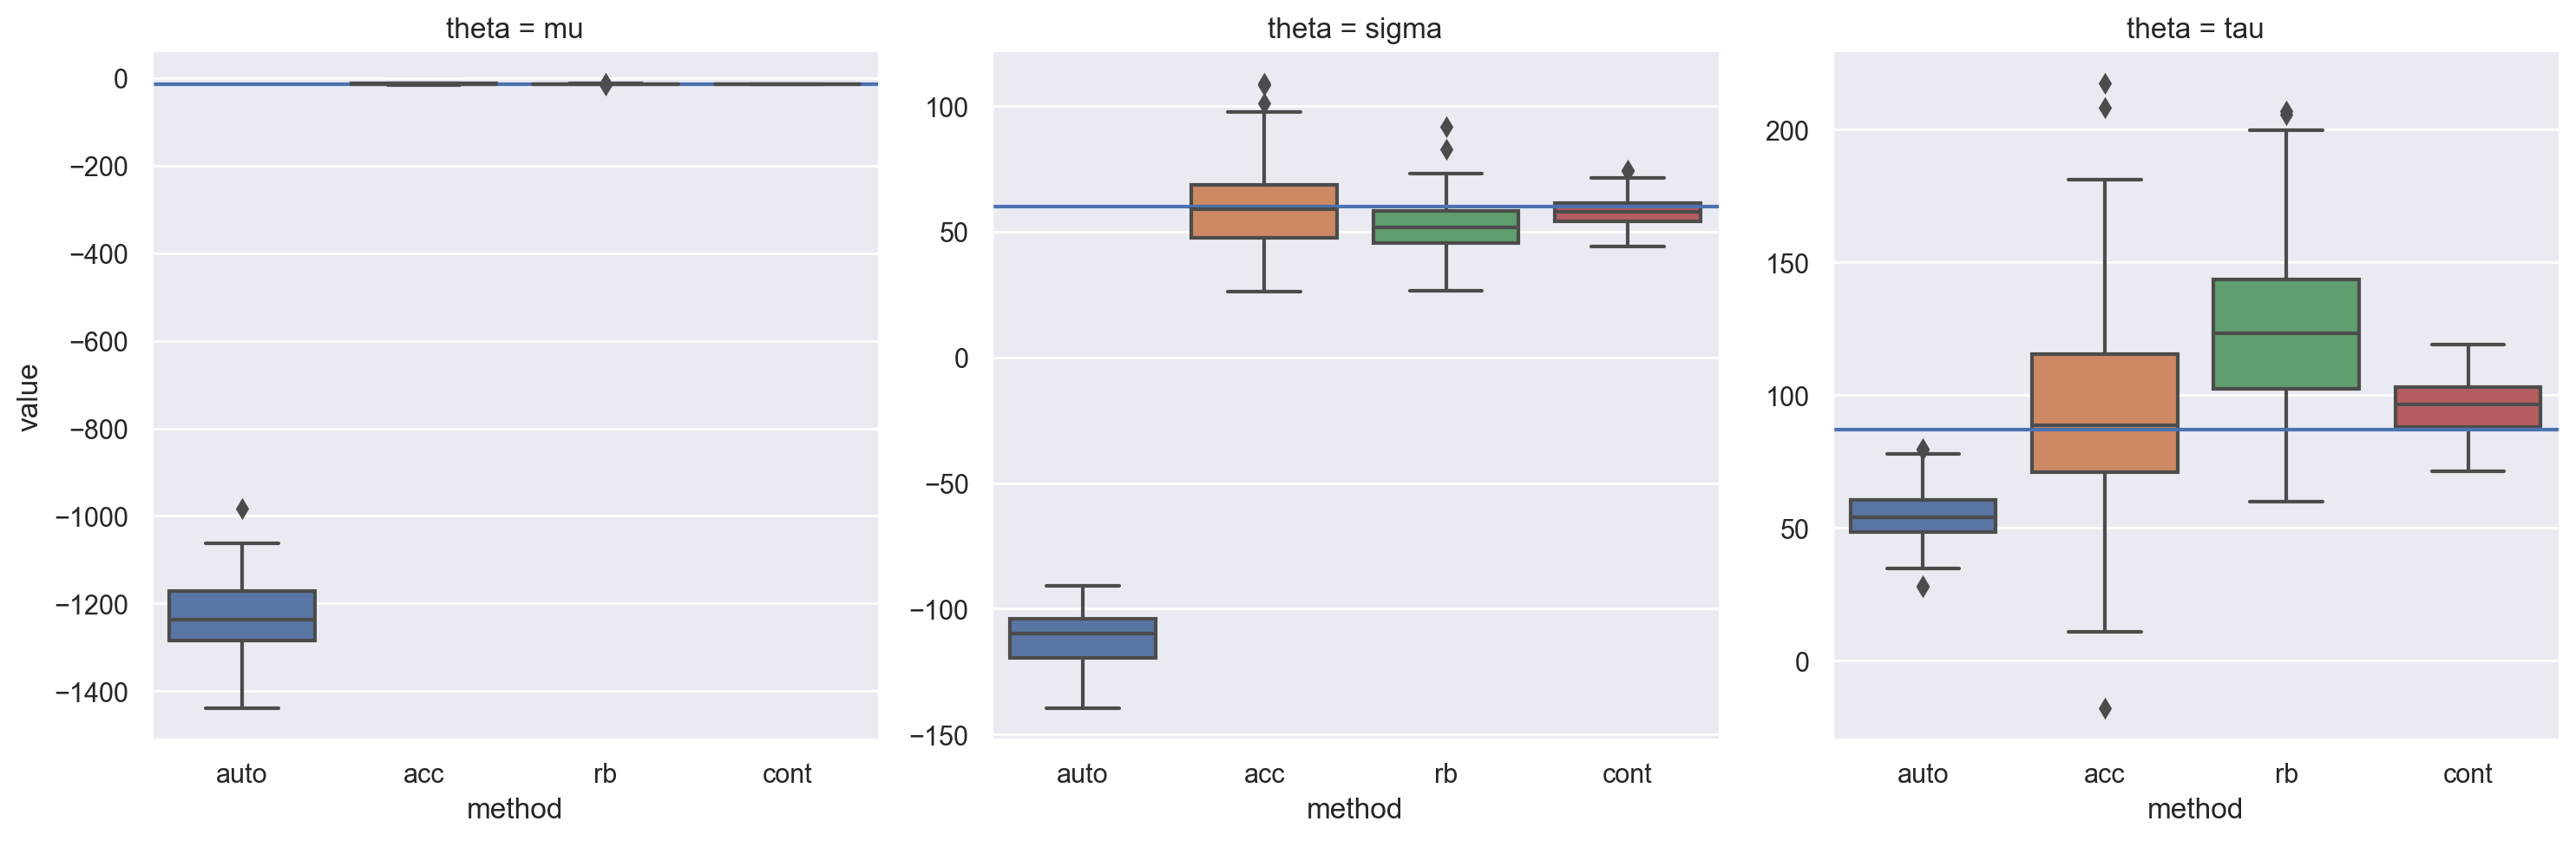

In [59]:
plot_df = (
    pd.DataFrame({
    "theta": np.tile(theta_names, n_sim),
    "auto": np.array(score_auto).ravel(),
    "acc": np.array(score_acc).ravel(),
    "rb": np.array(score_rb).ravel(),
    "cont": np.array(score_cont).ravel()
})
    .melt(id_vars=["theta"], value_vars=["auto", "acc", "rb", "cont"], var_name="method")
)

g = sns.catplot(
    data=plot_df, kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=3,
    sharey=False
)
[g.axes[i].axhline(score_exact[i]) for i in range(theta_true.size)];

# References

(<a id="cit-corenflos_etal21" href="#call-corenflos_etal21">Corenflos, Thornton <em>et al.</em>, 2021</a>) A. Corenflos, J. Thornton, G. Deligiannidis <em>et al.</em>, ``_Differentiable particle filtering via entropy-regularized optimal transport_'', Proceedings of the 38th international conference on machine learning, July 2021.  [online](https://proceedings.mlr.press/v139/corenflos21a.html)

(<a id="cit-cappe_moulines05" href="#call-cappe_moulines05">Cappé and Moulines, 2005</a>) O. Cappé and E. Moulines, ``_On the use of particle filtering for maximum likelihood parameter estimation_'', 13th European Signal Processing Conference,  2005.

(<a id="cit-poyiadjis_etal11" href="#call-poyiadjis_etal11">Poyiadjis, Doucet <em>et al.</em>, 2011</a>) Poyiadjis G., Doucet A. and Singh S. S., ``_Particle approximations of the score and observed information matrix in state space models with application to parameter estimation_'', Biometrika, vol. 98, number 1, pp. 65--80,  2011.  [online](https://academic.oup.com/biomet/article-lookup/doi/10.1093/biomet/asq062)

